This notebook is **STRICTLY** used to create the plots in the paper.

In [1]:
import os
import sys

import numpy as np
import pandas as pd

import scipy as sp
from scipy.interpolate import griddata

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import getdist
from getdist import plots, MCSamples

src_dir = '/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0/src'
if not src_dir in sys.path: sys.path.append(src_dir)
utils_dir = '/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0/src/utils'
if not utils_dir in sys.path: sys.path.append(utils_dir)
from constants import *
from CosmoFunc import *

from scipy.stats import norm
from scipy.optimize import curve_fit
from scipy.special import erf

from matplotlib.ticker import FormatStrFormatter

from step_7_fit_fp import fit_FP
from step_8_fit_logdist import fit_logdist

# Plot configurations
GOLDEN_RATIO = 0.5*(1+np.sqrt(5))
FIGURE_HEIGHT = 5
FIGURE_WIDTH = FIGURE_HEIGHT*GOLDEN_RATIO
DEFAULT_FIGSIZE = (FIGURE_WIDTH, FIGURE_HEIGHT)

# ROOT_PATH = '/Users/mrafifrbbn/Documents/thesis/thesis-research-2.0'
from dotenv import load_dotenv
load_dotenv()

ROOT_PATH = os.environ.get('ROOT_PATH')
SMIN_SETTING = int(os.environ.get('SMIN_SETTING'))
COMPLETENESS_SETTING = int(os.environ.get('COMPLETENESS_SETTING'))

# Figure 1. $ϵ_\text{SDSS-LAMOST}$ vs $s_\text{avg}$

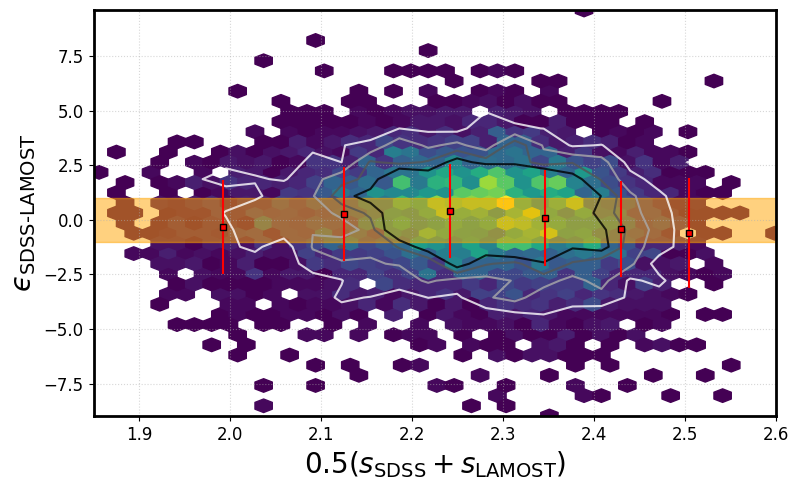

In [3]:
VELDISP_ORI_OUTPUT_FILEPATH = os.path.join(ROOT_PATH, 'data/processed/veldisp_calibrated/repeat_ori.csv')

df = pd.read_csv(VELDISP_ORI_OUTPUT_FILEPATH)
df = df[~(df['s_sdss'].isna()) & ~(df['s_lamost'].isna())]

# Calculate epsilon
df['epsilon'] = (df['s_sdss'] - df['s_lamost']) / np.sqrt(df['es_sdss']**2 + df['es_lamost']**2)
df = df[np.absolute(df['epsilon']) < 10.]
# Calculate the average (to avoid correlated errors)
df['s_avg'] = 0.5 * (df['s_sdss'] + df['s_lamost'])

# Prepare the bins
S_BIN_WIDTH = 50.
# bin_list = np.log10(np.arange(10**df['s_avg'].min(), 10**df['s_avg'].max() + S_BIN_WIDTH, S_BIN_WIDTH))
bin_list = np.log10(np.array([1., 112., 150., 200., 250., 300., 500.]))
bin_label = range(1, len(bin_list))
df['s_bin'] = pd.cut(df['s_avg'], bin_list, labels=bin_label)

# Create the figure
fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)

# Create hexbin plot and bin coordinate and its corresponding value
h = ax.hexbin(df['s_avg'], df['epsilon'], gridsize=(40, 20), mincnt=1)
xy = h.get_offsets()
x = xy[:, 0]
y = xy[:, 1]
v = h.get_array()

xi=np.linspace(x.min(), x.max(), 25)
yi=np.linspace(y.min(), y.max(), 25)

# Create contour plot
X,Y= np.meshgrid(xi,yi)
Z = griddata((x, y), v, (X, Y), method='cubic')
ax.contour(X, Y, Z, levels=[5, 10, 15, 20], cmap='gist_yarg', alpha=0.8)

# Create binned epsilon
df_grouped = df.groupby(['s_bin'], observed=False).agg(bin_count=('epsilon', 'count'), s_avg_mean=('s_avg', 'mean'), epsilon_mean=('epsilon', 'mean'), epsilon_std=('epsilon', 'std'))
df_grouped['mean_error'] = df_grouped['epsilon_std'] / np.sqrt(df_grouped['bin_count'])
ax.errorbar(x=df_grouped['s_avg_mean'], y=df_grouped['epsilon_mean'], yerr=df_grouped['epsilon_std'], marker='s', mfc='red',
         mec='k', ms=5, mew=1, ecolor='red', color='red', ls='none')

# Create horizontal line
# ax.axhline(y=0, color='k', ls='--')
# ax.axhline(y=1, color='k', ls=':')
# ax.axhline(y=-1, color='k', ls=':')
ax.fill_between(x=[1.8, 2.6], y1=[1.0, 1.0], y2=[-1.0, -1.0], alpha=0.5, color='orange')
ax.grid(ls=':', alpha=0.5)

# Labels and stuff
ax.set_xlabel(r'$0.5(s_\text{SDSS} + s_\text{LAMOST})$', fontsize=20)
ax.set_ylabel(r'$ϵ_\text{SDSS-LAMOST}$', fontsize=20)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_xlim(1.85, 2.6)

for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

# Save figure
fig.tight_layout()
# plt.savefig('../img/final_plot/epsilon_vs_savg.pdf', dpi=300)

plt.show()

# Figure 2. Veldisp pairwise errors before vs after

Generating comparison plot with the following inputs:
Method: lamost_only
k_6df: 1.0
k_sdss: 1.0
k_lamost: 2.638467792758444
off_6df: -0.0225179884863242
off_sdss: 0.0
off_lamost: -0.0059356239175928

Comparison between 6df and sdss before scaling. Ngal = 6541...
- Mean of ϵ is -0.562 with standard error in the mean of 0.103. Therefore it is -5.448σ away from the expected 0.
- Std of ϵ is 0.661 with standard error in the std of 0.074. Therefore it is -4.595σ away from the expected 1.
Comparison between 6df and sdss after scaling. Ngal = 6541...
- Mean of ϵ is -0.164 with standard error in the mean of 0.106. Therefore it is -1.544σ away from the expected 0.
- Std of ϵ is 0.678 with standard error in the std of 0.076. Therefore it is -4.245σ away from the expected 1.

Comparison between sdss and lamost before scaling. Ngal = 6541...
- Mean of ϵ is 0.269 with standard error in the mean of 0.027. Therefore it is 9.791σ away from the expected 0.
- Std of ϵ is 2.21 with standard error in the

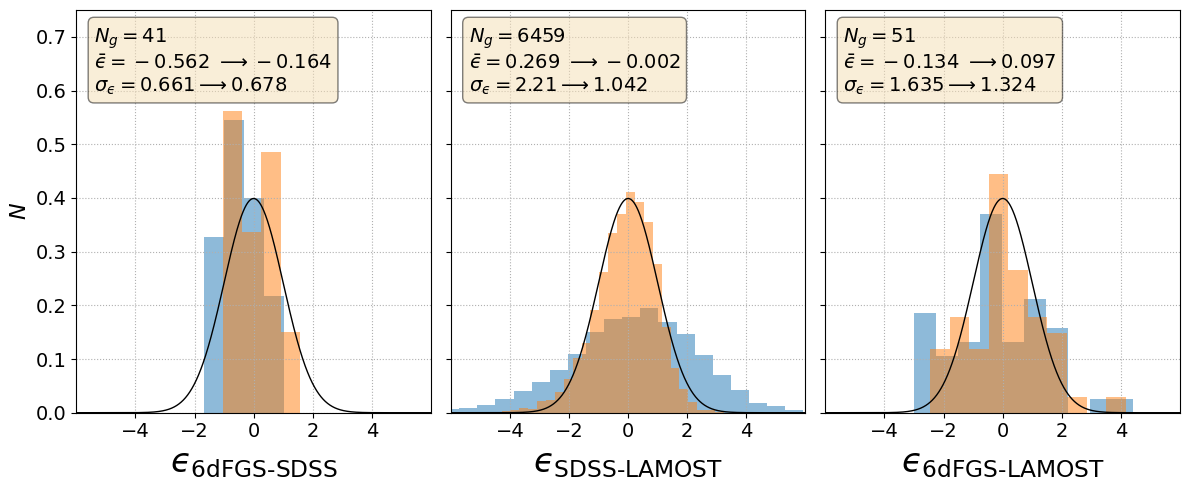

In [2]:
VELDISP_ORI_OUTPUT_FILEPATH = os.path.join(ROOT_PATH, 'data/processed/veldisp_calibrated/repeat_ori.csv')

method = 'lamost_only'

off_6df, off_sdss, off_lamost = pd.read_csv('../artifacts/veldisp_calibration/totoffs.csv').loc[0].to_numpy()
k_6df, k_sdss, k_lamost = pd.read_csv(f'../artifacts/veldisp_calibration/scaling_{method}.csv').loc[0].to_numpy()

# CONSTANTS
BIN_LIST = [4, 40, 10]
XLIM_LIST = [(-6, 6), (-6, 6), (-6, 6)]
SURVEY_COMBOS = [('6df', 'sdss'), ('sdss', 'lamost'), ('6df', 'lamost')]
XLABEL_LIST = [r'$ϵ_\text{6dFGS-SDSS}$', r'$ϵ_\text{SDSS-LAMOST}$', r'$ϵ_\text{6dFGS-LAMOST}$']

print('Generating comparison plot with the following inputs:')
print(f'Method: {method}')
print(f'k_6df: {k_6df}')
print(f'k_sdss: {k_sdss}')
print(f'k_lamost: {k_lamost}')
print(f'off_6df: {off_6df}')
print(f'off_sdss: {off_sdss}')
print(f'off_lamost: {off_lamost}')
print()

df = pd.read_csv(VELDISP_ORI_OUTPUT_FILEPATH)
# off_6df = 0.
# off_sdss = 0.
# off_lamost = 0.
# Apply the offsets
df['s_6df_scaled'] = df['s_6df'] - off_6df
df['es_6df_scaled'] = df['es_6df'] * k_6df
df['s_sdss_scaled'] = df['s_sdss'] - off_sdss
df['es_sdss_scaled'] = df['es_sdss'] * k_sdss
df['s_lamost_scaled'] = df['s_lamost'] - off_lamost
df['es_lamost_scaled'] = df['es_lamost'] * k_lamost

fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 5))

for i, combo in enumerate(SURVEY_COMBOS):
    survey_1, survey_2 = combo

    # Calculate original statistics
    epsilon = (df[f's_{survey_1}'] - df[f's_{survey_2}']) / np.sqrt(df[f'es_{survey_1}']**2 + df[f'es_{survey_2}']**2)
    Ngal = epsilon.notna().sum()
    # Calculate mean, std, and standard errors in them
    eps_mean = epsilon.median()
    eps_std = epsilon.std()
    eps_mean_stderr = eps_std / np.sqrt(Ngal)
    eps_std_stderr = eps_std / np.sqrt(2 * (Ngal - 1))
    mean_severity = eps_mean / eps_mean_stderr
    std_severity = (eps_std - 1.0) / eps_std_stderr

    print(f"Comparison between {survey_1} and {survey_2} before scaling. Ngal = {len(df)}...")
    print(f'- Mean of ϵ is {np.round(eps_mean, 3)} with standard error in the mean of {np.round(eps_mean_stderr, 3)}. Therefore it is {np.round(mean_severity, 3)}σ away from the expected 0.')
    print(f'- Std of ϵ is {np.round(eps_std, 3)} with standard error in the std of {np.round(eps_std_stderr, 3)}. Therefore it is {np.round(std_severity, 3)}σ away from the expected 1.')

    # Calculate statistics after scaling and offset
    epsilon_scaled = (df[f's_{survey_1}_scaled'] - df[f's_{survey_2}_scaled']) / np.sqrt(df[f'es_{survey_1}_scaled']**2 + df[f'es_{survey_2}_scaled']**2)
    Ngal_scaled = epsilon_scaled.notna().sum()
    # Calculate mean, std, and standard errors in them
    eps_scaled_mean = epsilon_scaled.median()
    eps_scaled_std = epsilon_scaled.std()
    eps_scaled_mean_stderr = eps_scaled_std / np.sqrt(Ngal_scaled)
    eps_scaled_std_stderr = eps_scaled_std / np.sqrt(2 * (Ngal_scaled - 1))
    scaled_mean_severity = eps_scaled_mean / eps_scaled_mean_stderr
    scaled_std_severity = (eps_scaled_std - 1.0) / eps_scaled_std_stderr

    print(f"Comparison between {survey_1} and {survey_2} after scaling. Ngal = {len(df)}...")
    print(f'- Mean of ϵ is {np.round(eps_scaled_mean, 3)} with standard error in the mean of {np.round(eps_scaled_mean_stderr, 3)}. Therefore it is {np.round(scaled_mean_severity, 3)}σ away from the expected 0.')
    print(f'- Std of ϵ is {np.round(eps_scaled_std, 3)} with standard error in the std of {np.round(eps_scaled_std_stderr, 3)}. Therefore it is {np.round(scaled_std_severity, 3)}σ away from the expected 1.')

    axs[i].hist(epsilon, bins=BIN_LIST[i], density=True, alpha=0.5)
    axs[i].hist(epsilon_scaled, bins=BIN_LIST[i], density=True, alpha=0.5)

    # Write the before and after statistics
    textstr = '\n'.join((
        fr'$N_g = {Ngal}$',
        r'$\bar{ϵ}=%.3f$' % eps_mean + fr' $\longrightarrow {np.round(eps_scaled_mean, 3)}$',
        fr'$\sigma_ϵ={np.round(eps_std, 3)} \longrightarrow {np.round(eps_scaled_std, 3)}$'))
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    axs[i].text(-5.4, 0.72, textstr, fontsize=14,
            verticalalignment='top', bbox=props)

    # Misc
    axs[i].grid(linestyle=":")
    axs[i].set_xlim(XLIM_LIST[i])
    axs[i].set_ylim(0., 0.75)
    axs[i].set_xlabel(XLABEL_LIST[i], fontsize=24)
    axs[i].set_xticks(axs[i].get_xticks()[1:-1])
    axs[0].set_ylabel(r'$N$', fontsize=16)
    
    print()

# Plot standard normal Gaussians (target)
x = np.arange(start=-10., stop=10., step=0.0001)
y = norm.pdf(x, loc=0., scale=1.)
for ax in axs:
    ax.plot(x, y, c='k', lw=1.0)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

plt.subplots_adjust(wspace=0)

plt.tight_layout()
# fig.savefig('../img/final_plot/veldisp_comparison.pdf', bbox_inches='tight', dpi=300)

# Figure 3. Redshift, Magnitude, and FP observables distributions

6dFGS | 6158
SDSS | 4405
LAMOST | 2123


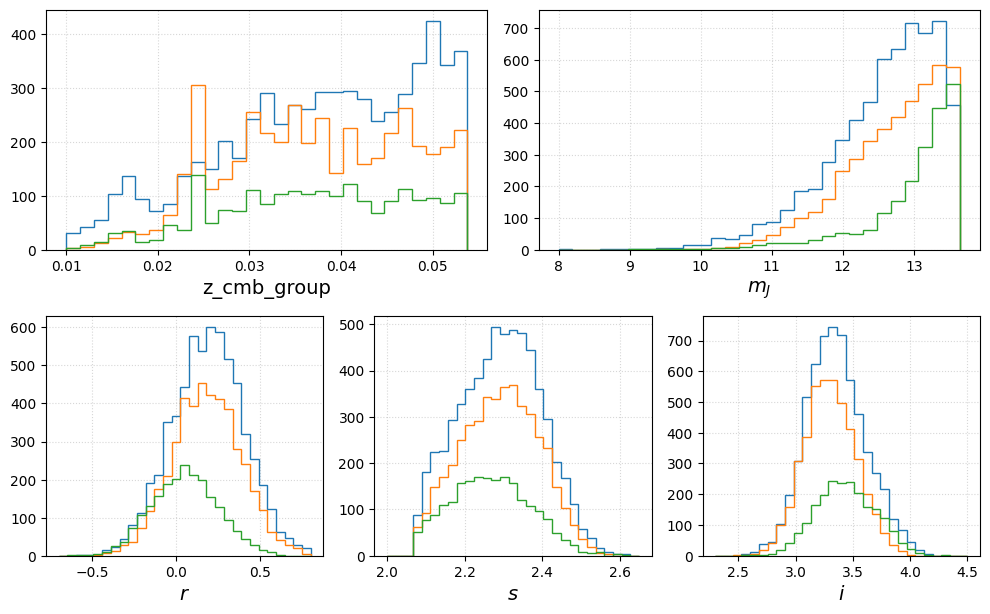

In [3]:
# Create a figure
fig = plt.figure(figsize=(10, 18))

# Create a GridSpec with 3 rows and 3 columns
gs = gridspec.GridSpec(6, 6, figure=fig)

# First row, two equal sized columns
ax1 = fig.add_subplot(gs[0, 0:3])
ax2 = fig.add_subplot(gs[0, 3:])
# Second row, three equal sized columns
ax3 = fig.add_subplot(gs[1, 0:2])
ax4 = fig.add_subplot(gs[1, 2:4])
ax5 = fig.add_subplot(gs[1, 4:6])

# Column names and labels
cols = ['z_dist_est', 'mag_j', 'r', 's', 'i']
col_labels = ['z_cmb_group', r'$m_J$', r'$r$', r'$s$', r'$i$']

# Number of bins
N_BINS = 30

# Define the bins
hist_bins = {
    "z_dist_est": np.linspace(ZMIN, ZMAX, N_BINS), # redshift bins
    "mag_j": np.linspace(MAG_LOW, MAG_HIGH, N_BINS), # magnitude bins
    "r": np.linspace(-0.7, 0.8, N_BINS), # radius bins
    "s": np.linspace(2.0, 2.65, N_BINS), # veldisp bins
    "i": np.linspace(2.3, 4.5, N_BINS) # intensity bins
}

for survey in SURVEY_LIST:
    df = pd.read_csv(f'../data/foundation/fp_sample_final/smin_setting_1/{survey.lower()}.csv')
    print(survey, '|', len(df))
    df['mag_j'] = df['j_m_ext'] - df['extinction_j']

    for i, col in enumerate(cols):
        ax = fig.axes[i]
        ax.hist(df[col], bins=hist_bins.get(col), histtype='step')
        ax.set_xlabel(col_labels[i], fontsize=14)
#         ax.set_ylabel(r'$N$', fontsize=14)
#         ax.set_yscale('log')

for ax in fig.axes:
    ax.grid(ls=':', alpha=0.5)

# Adjust layout to make it look nice
fig.tight_layout()
# fig.savefig('../img/final_plot/fp_distributions.pdf', bbox_inches='tight', dpi=300)

# Figure 4. Photometric Error Model

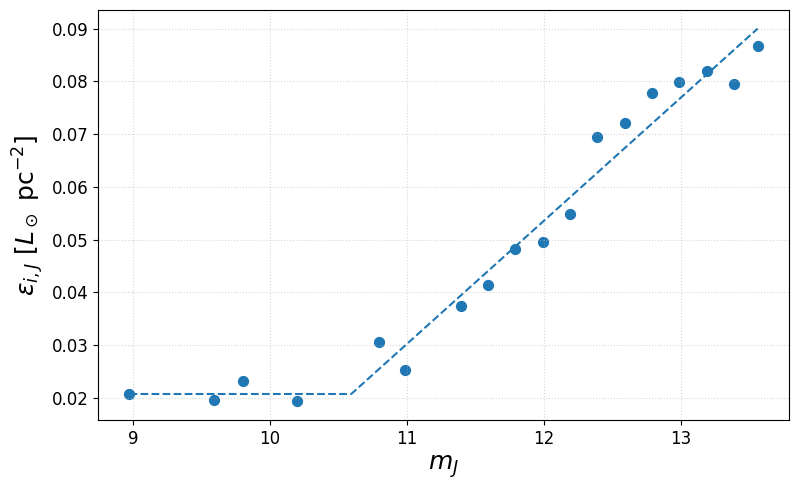

In [2]:
def piecewise_linear(x: np.ndarray, x0: float, y0: float, k: float) -> np.ndarray:
    '''
    A function that is constant at x <= x0, and linear at x > x0.
    '''
    y_pred = np.piecewise(x, [x <= x0, x > x0], [lambda x: y0, lambda x: k * (x - x0) + y0])
    return y_pred

# Load the model
popt = pd.read_csv('../artifacts/phot_error/smin_setting_1/model.csv').to_numpy()[0]

# Load the data
x_data = np.load('../artifacts/phot_error/smin_setting_1/xdata.npy')
y_data = np.load('../artifacts/phot_error/smin_setting_1/ydata.npy')

# Load trial x and y
x_trial = np.linspace(np.min(x_data), np.max(x_data), 1000)
y_trial = piecewise_linear(x_trial, *popt)

fig, ax = plt.subplots(figsize=DEFAULT_FIGSIZE)

ax.scatter(x_data, y_data, s=50)
ax.plot(x_trial, y_trial, ls='--')
ax.set_xlabel(r'$m_J$', fontsize=18)
ax.set_ylabel(r'$\epsilon_{i, J}\ [L_\odot\ \mathrm{pc}^{-2}]$', fontsize=18)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.grid(ls=':', alpha=0.5)

fig.tight_layout()
# fig.savefig('../img/final_plot/phot_errors.pdf', bbox_inches='tight', dpi=300)

# Figure 5. FP Likelihood Cornerplot

Removed no burn in
Removed no burn in
Removed no burn in


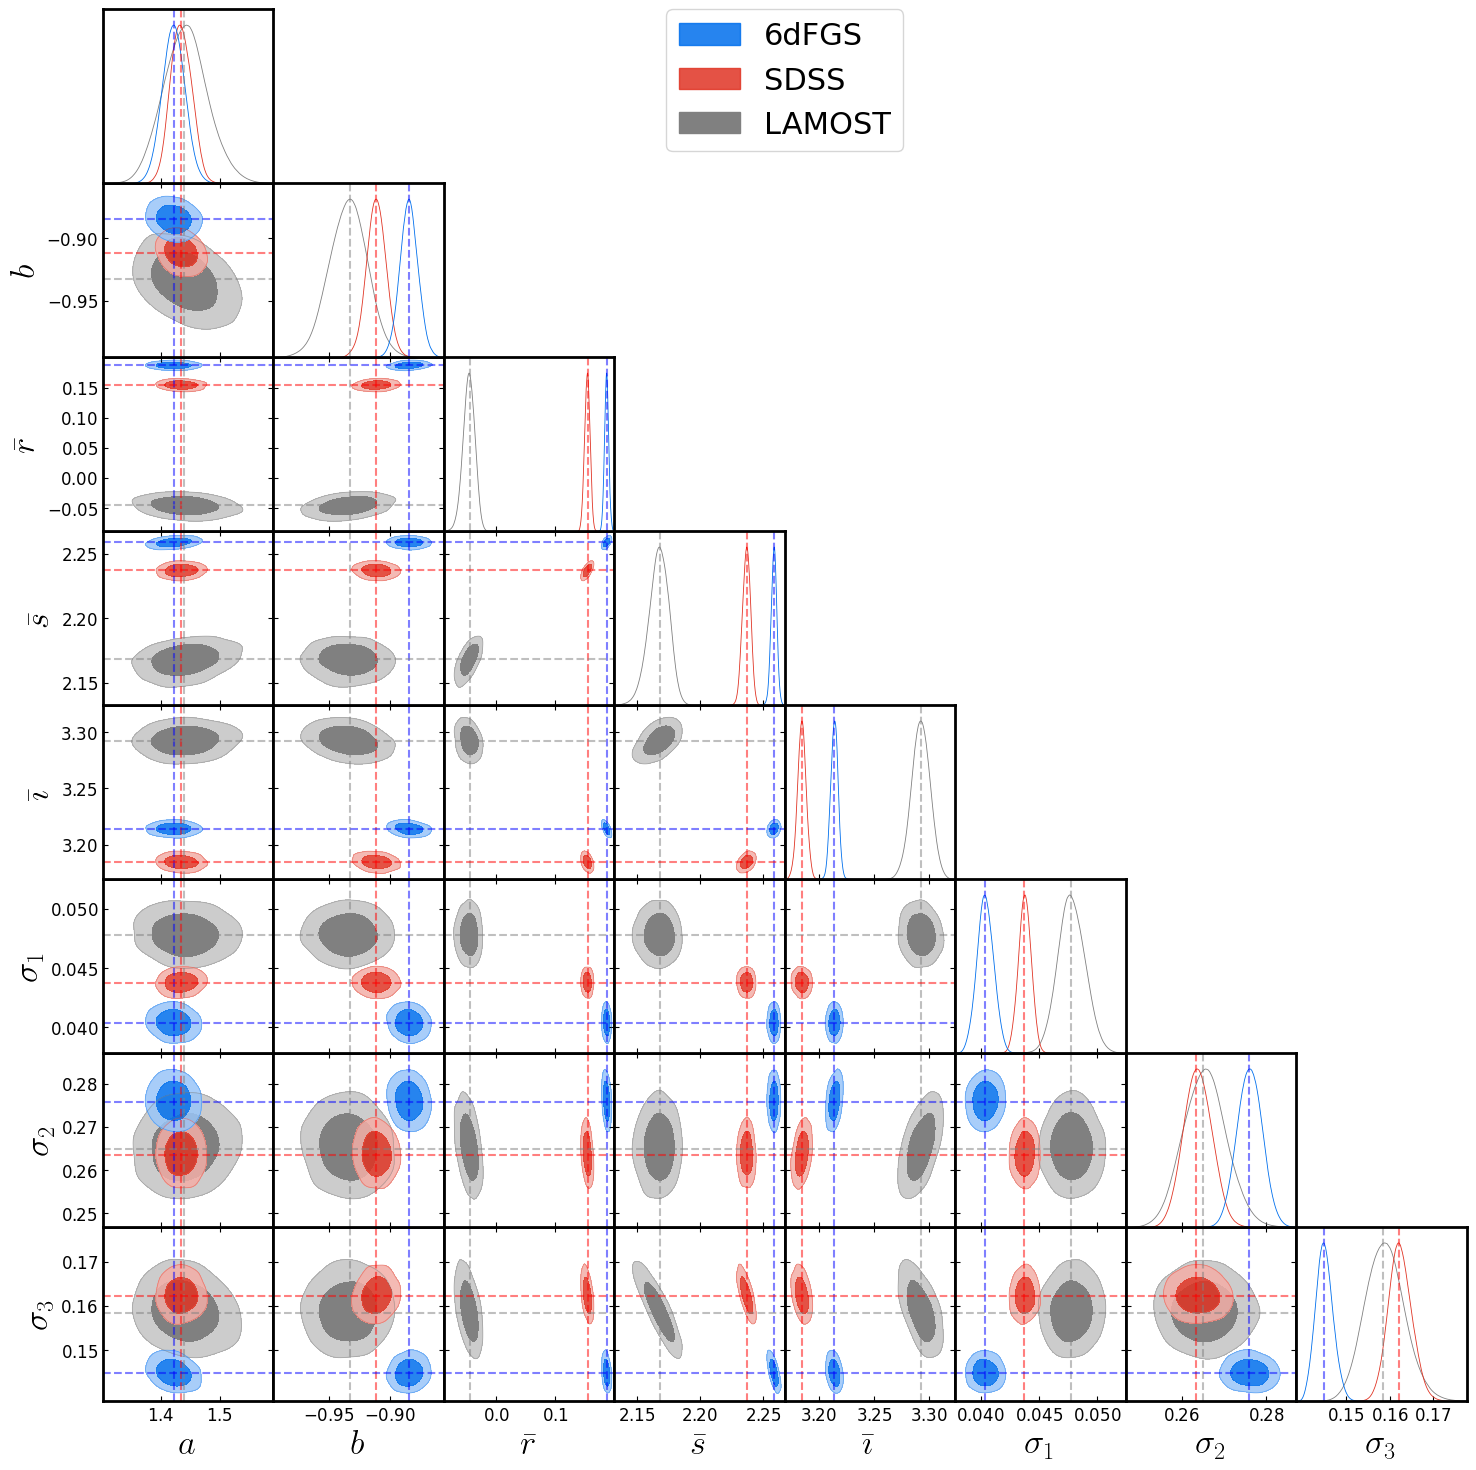

In [56]:
FP_FIT_FILEPATH = os.path.join(ROOT_PATH, f'artifacts/fp_fit/smin_setting_{SMIN_SETTING}/fp_fits.csv')

FP_FIT_METHOD = 0
MCMC_CHAIN_OUTPUT_FILEPATH = {
    '6dFGS': os.path.join(ROOT_PATH, f'artifacts/fp_fit/smin_setting_{SMIN_SETTING}/fp_fit_method_{FP_FIT_METHOD}/6dfgs_chain.npy'),
    'SDSS': os.path.join(ROOT_PATH, f'artifacts/fp_fit/smin_setting_{SMIN_SETTING}/fp_fit_method_{FP_FIT_METHOD}/sdss_chain.npy'),
    'LAMOST': os.path.join(ROOT_PATH, f'artifacts/fp_fit/smin_setting_{SMIN_SETTING}/fp_fit_method_{FP_FIT_METHOD}/lamost_chain.npy')
}

mpl.rcParams['axes.linewidth'] = 2.0
mpl.rcParams['font.family'] = 'sans-serif'

# 6dFGS data (mocks and previous values)
samples_6df = np.load(MCMC_CHAIN_OUTPUT_FILEPATH['6dFGS'])
prev_vals_6df = pd.read_csv(FP_FIT_FILEPATH, index_col=0).loc['6dFGS'].to_numpy()

# SDSS data (mocks and previous values)
samples_sdss = np.load(MCMC_CHAIN_OUTPUT_FILEPATH['SDSS'])
prev_vals_sdss = pd.read_csv(FP_FIT_FILEPATH, index_col=0).loc['SDSS'].to_numpy()

# LAMOST data (mocks and previous values)
samples_lamost = np.load(MCMC_CHAIN_OUTPUT_FILEPATH['LAMOST'])
prev_vals_lamost = pd.read_csv(FP_FIT_FILEPATH, index_col=0).loc['LAMOST'].to_numpy()

# parameter names
names = [r'$a$', r'$b$', r'$\bar{r}$', r'$\bar{s}$', r'$\bar{\imath}$', r'$\sigma_1$', r'$\sigma_2$', r'$\sigma_3$']

samples1 = getdist.MCSamples(samples=samples_6df, names=names, label='6dFGS')
samples2 = getdist.MCSamples(samples=samples_sdss, names=names, label='SDSS')
samples3 = getdist.MCSamples(samples=samples_lamost, names=names, label='LAMOST')

# Triangle plot
g = getdist.plots.get_subplot_plotter()
g.settings.legend_fontsize = 25
g.settings.axes_fontsize = 15
g.settings.axes_labelsize = 20

g.triangle_plot([samples3, samples2, samples1], filled=True, label_order=[2, 1, 0])

ndim = 8
for i in range(ndim):    
    for j in range(ndim):
        if j<=i:
            ax = g.subplots[i,j]
            ax.axvline(prev_vals_6df[j], color='blue', ls='--', alpha=0.5)
            ax.axvline(prev_vals_sdss[j], color='red', ls='--', alpha=0.5)
            ax.axvline(prev_vals_lamost[j], color='grey', ls='--', alpha=0.5)
            ax.set_xlabel(ax.get_xlabel(), usetex=True, fontsize=25, family='sans-serif')
            ax.set_ylabel(ax.get_ylabel(), usetex=True, fontsize=25, family='sans-serif')

            if i != j:
                ax.axhline(prev_vals_6df[i], color='blue', ls='--', alpha=0.5)
                ax.axhline(prev_vals_sdss[i], color='red', ls='--', alpha=0.5)
                ax.axhline(prev_vals_lamost[i], color='grey', ls='--', alpha=0.5)

g.export('../img/final_plot/fig_5_fp_likelihood.pdf', dpi=300)

Removed no burn in
Removed no burn in
Removed no burn in


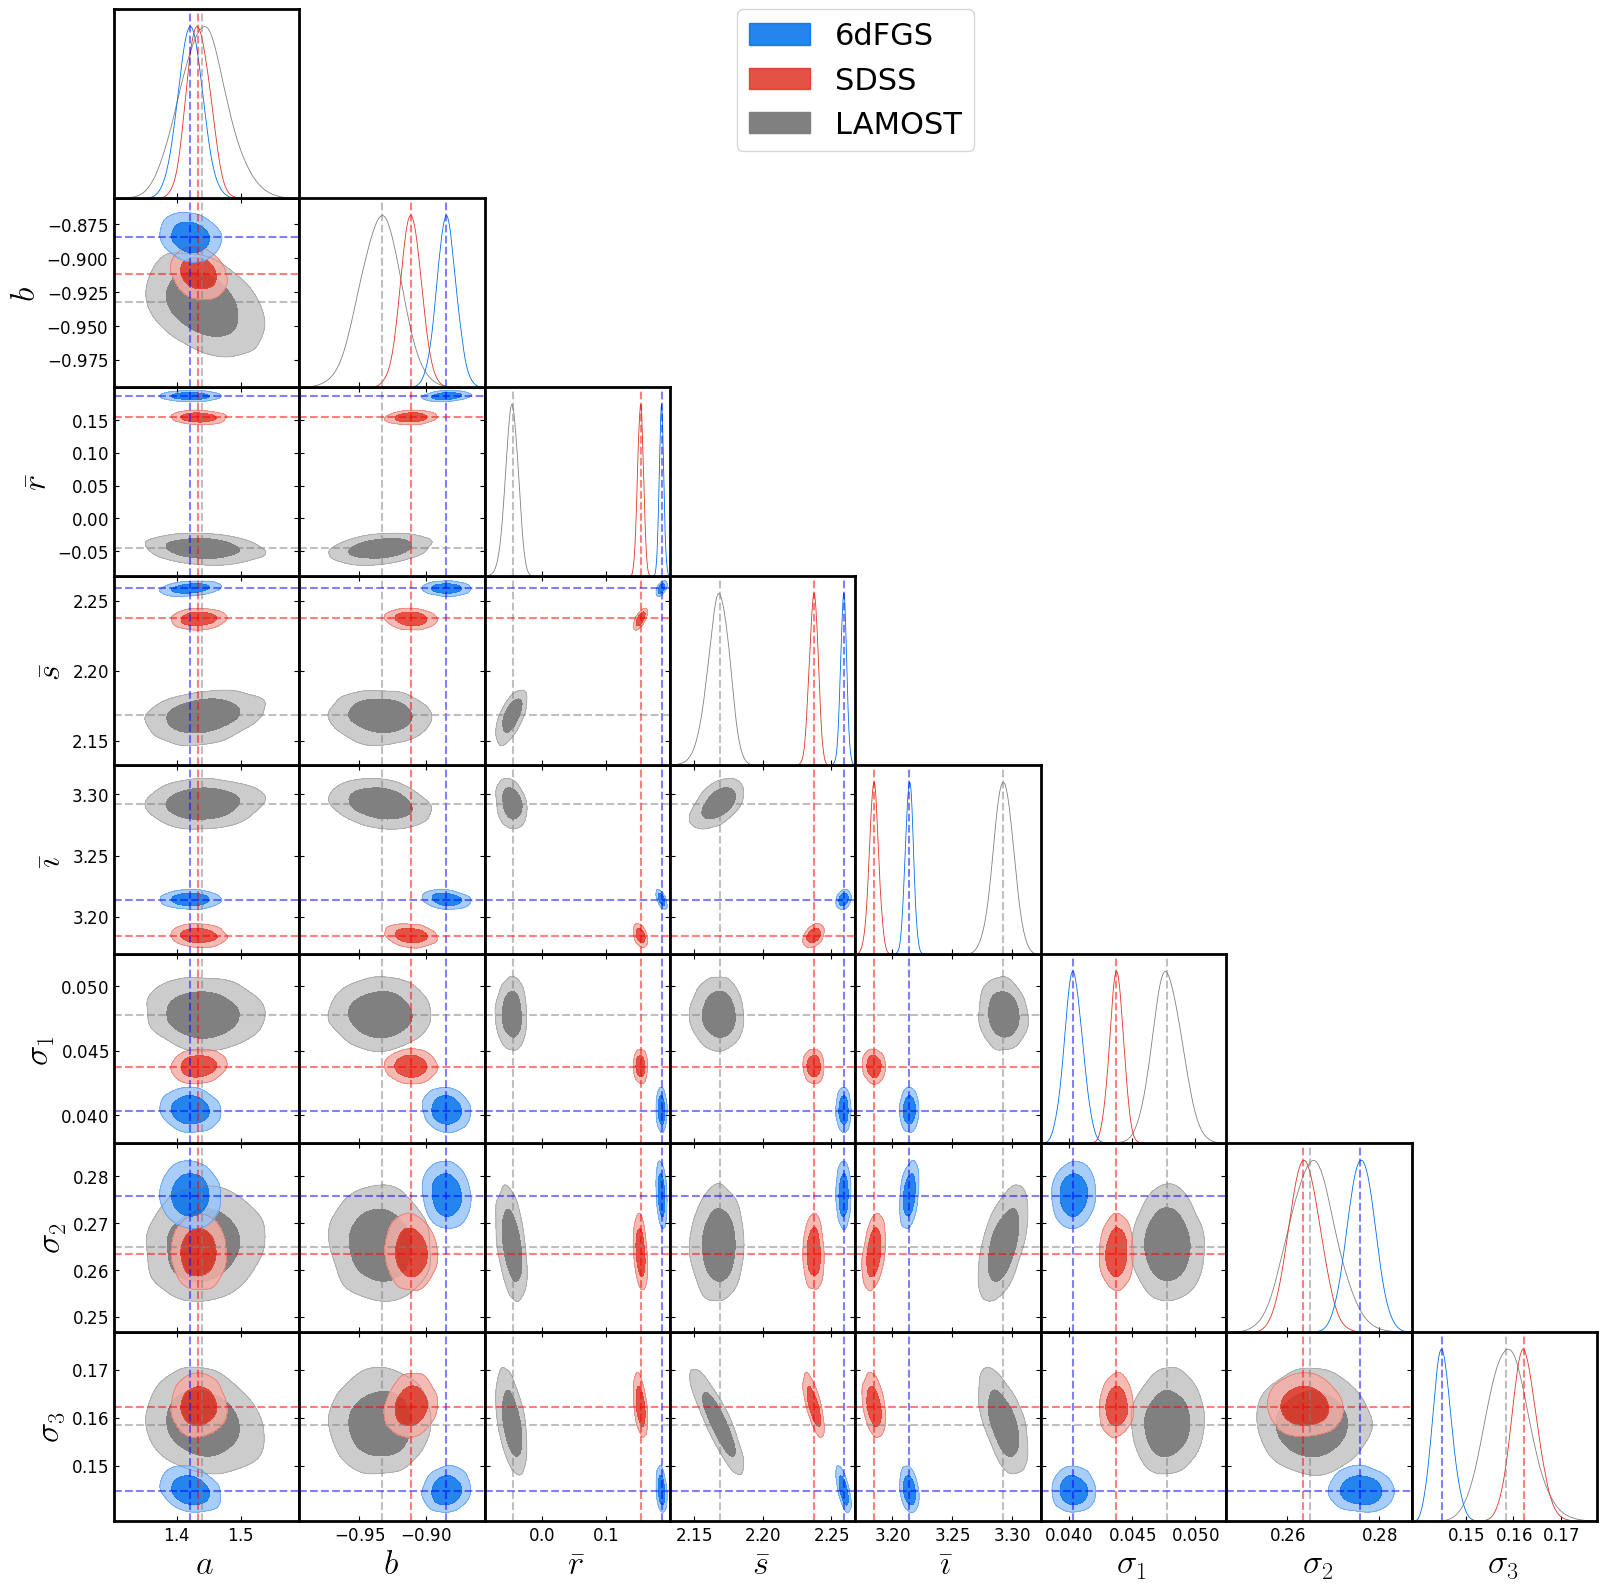

In [5]:
FP_FIT_METHOD = 0

FP_FIT_FILEPATH = os.path.join(ROOT_PATH, f'artifacts/fp_fit/smin_setting_{SMIN_SETTING}/fp_fit_method_{FP_FIT_METHOD}/fp_fits.csv')

MCMC_CHAIN_OUTPUT_FILEPATH = {
    '6dFGS': os.path.join(ROOT_PATH, f'artifacts/fp_fit/smin_setting_{SMIN_SETTING}/fp_fit_method_{FP_FIT_METHOD}/6dfgs_chain.npy'),
    'SDSS': os.path.join(ROOT_PATH, f'artifacts/fp_fit/smin_setting_{SMIN_SETTING}/fp_fit_method_{FP_FIT_METHOD}/sdss_chain.npy'),
    'LAMOST': os.path.join(ROOT_PATH, f'artifacts/fp_fit/smin_setting_{SMIN_SETTING}/fp_fit_method_{FP_FIT_METHOD}/lamost_chain.npy')
}

mpl.rcParams['axes.linewidth'] = 2.0
mpl.rcParams['font.family'] = 'sans-serif'

# 6dFGS data (mocks and previous values)
samples_6df = np.load(MCMC_CHAIN_OUTPUT_FILEPATH['6dFGS'])
prev_vals_6df = pd.read_csv(FP_FIT_FILEPATH, index_col=0).loc['6dFGS'].to_numpy()

# SDSS data (mocks and previous values)
samples_sdss = np.load(MCMC_CHAIN_OUTPUT_FILEPATH['SDSS'])
prev_vals_sdss = pd.read_csv(FP_FIT_FILEPATH, index_col=0).loc['SDSS'].to_numpy()

# LAMOST data (mocks and previous values)
samples_lamost = np.load(MCMC_CHAIN_OUTPUT_FILEPATH['LAMOST'])
prev_vals_lamost = pd.read_csv(FP_FIT_FILEPATH, index_col=0).loc['LAMOST'].to_numpy()

# parameter names
names = [r'$a$', r'$b$', r'$\bar{r}$', r'$\bar{s}$', r'$\bar{\imath}$', r'$\sigma_1$', r'$\sigma_2$', r'$\sigma_3$']

samples1 = getdist.MCSamples(samples=samples_6df, names=names, label='6dFGS')
samples2 = getdist.MCSamples(samples=samples_sdss, names=names, label='SDSS')
samples3 = getdist.MCSamples(samples=samples_lamost, names=names, label='LAMOST')

# Triangle plot
g = getdist.plots.get_subplot_plotter()
g.settings.legend_fontsize = 25
g.settings.axes_fontsize = 15
g.settings.axes_labelsize = 20

g.triangle_plot([samples3, samples2, samples1], filled=True, label_order=[2, 1, 0])

ndim = 8
for i in range(ndim):    
    for j in range(ndim):
        if j<=i:
            ax = g.subplots[i,j]
            ax.axvline(prev_vals_6df[j], color='blue', ls='--', alpha=0.5)
            ax.axvline(prev_vals_sdss[j], color='red', ls='--', alpha=0.5)
            ax.axvline(prev_vals_lamost[j], color='grey', ls='--', alpha=0.5)
            ax.set_xlabel(ax.get_xlabel(), usetex=True, fontsize=25, family='sans-serif')
            ax.set_ylabel(ax.get_ylabel(), usetex=True, fontsize=25, family='sans-serif')

            if i != j:
                ax.axhline(prev_vals_6df[i], color='blue', ls='--', alpha=0.5)
                ax.axhline(prev_vals_sdss[i], color='red', ls='--', alpha=0.5)
                ax.axhline(prev_vals_lamost[i], color='grey', ls='--', alpha=0.5)

# g.export('../img/final_plot/fig_5_fp_likelihood.pdf', dpi=300)

Removed no burn in
Removed no burn in
Removed no burn in


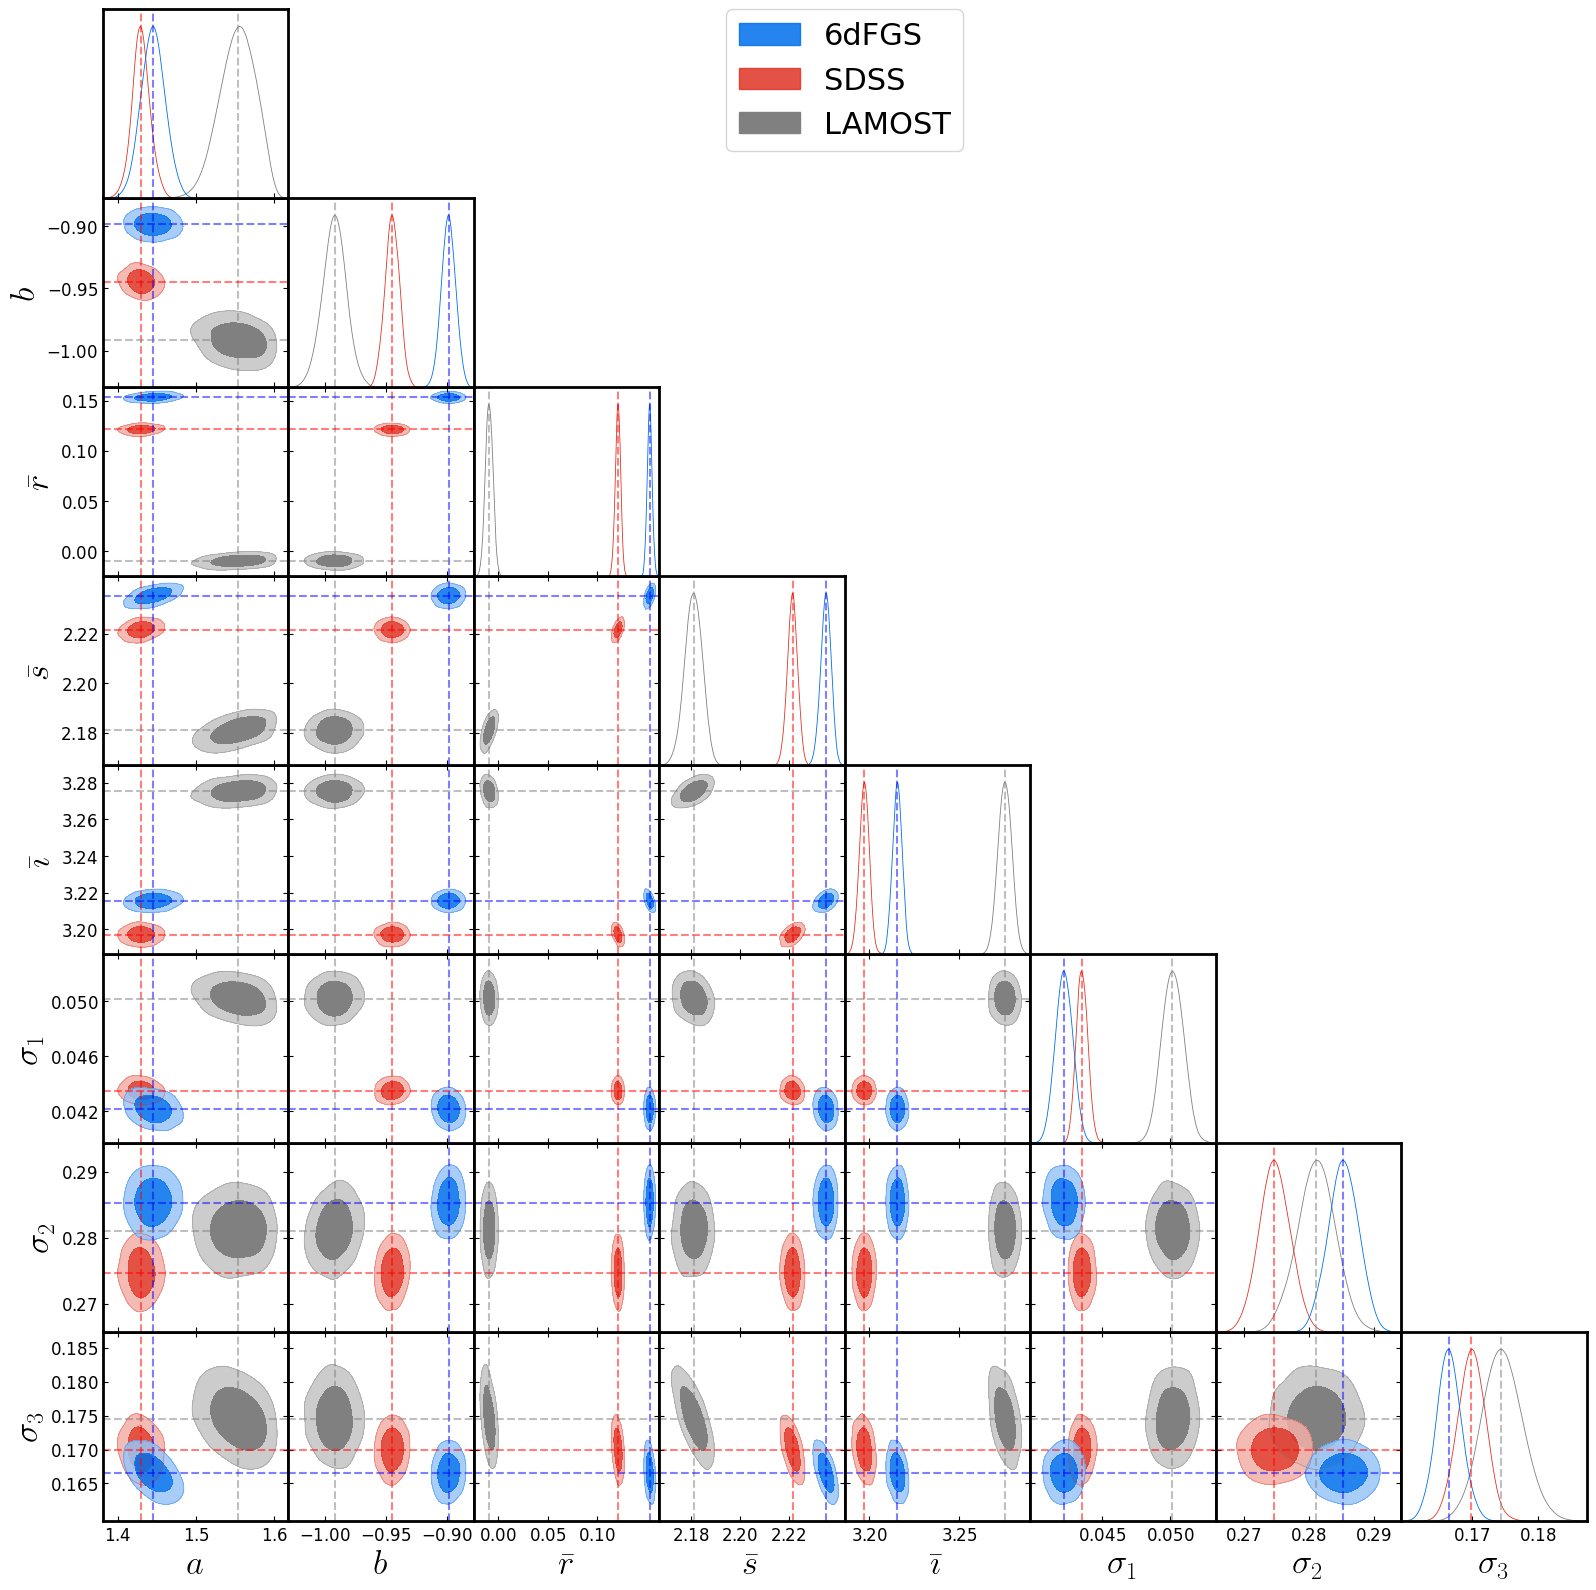

In [7]:
FP_FIT_METHOD = 1

FP_FIT_FILEPATH = os.path.join(ROOT_PATH, f'artifacts/fp_fit/smin_setting_{SMIN_SETTING}/fp_fit_method_{FP_FIT_METHOD}/fp_fits.csv')

MCMC_CHAIN_OUTPUT_FILEPATH = {
    '6dFGS': os.path.join(ROOT_PATH, f'artifacts/fp_fit/smin_setting_{SMIN_SETTING}/fp_fit_method_{FP_FIT_METHOD}/6dfgs_chain.npy'),
    'SDSS': os.path.join(ROOT_PATH, f'artifacts/fp_fit/smin_setting_{SMIN_SETTING}/fp_fit_method_{FP_FIT_METHOD}/sdss_chain.npy'),
    'LAMOST': os.path.join(ROOT_PATH, f'artifacts/fp_fit/smin_setting_{SMIN_SETTING}/fp_fit_method_{FP_FIT_METHOD}/lamost_chain.npy')
}

mpl.rcParams['axes.linewidth'] = 2.0
mpl.rcParams['font.family'] = 'sans-serif'

# 6dFGS data (mocks and previous values)
samples_6df = np.load(MCMC_CHAIN_OUTPUT_FILEPATH['6dFGS'])
prev_vals_6df = pd.read_csv(FP_FIT_FILEPATH, index_col=0).loc['6dFGS'].to_numpy()

# SDSS data (mocks and previous values)
samples_sdss = np.load(MCMC_CHAIN_OUTPUT_FILEPATH['SDSS'])
prev_vals_sdss = pd.read_csv(FP_FIT_FILEPATH, index_col=0).loc['SDSS'].to_numpy()

# LAMOST data (mocks and previous values)
samples_lamost = np.load(MCMC_CHAIN_OUTPUT_FILEPATH['LAMOST'])
prev_vals_lamost = pd.read_csv(FP_FIT_FILEPATH, index_col=0).loc['LAMOST'].to_numpy()

# parameter names
names = [r'$a$', r'$b$', r'$\bar{r}$', r'$\bar{s}$', r'$\bar{\imath}$', r'$\sigma_1$', r'$\sigma_2$', r'$\sigma_3$']

samples1 = getdist.MCSamples(samples=samples_6df, names=names, label='6dFGS')
samples2 = getdist.MCSamples(samples=samples_sdss, names=names, label='SDSS')
samples3 = getdist.MCSamples(samples=samples_lamost, names=names, label='LAMOST')

# Triangle plot
g = getdist.plots.get_subplot_plotter()
g.settings.legend_fontsize = 25
g.settings.axes_fontsize = 15
g.settings.axes_labelsize = 20

g.triangle_plot([samples3, samples2, samples1], filled=True, label_order=[2, 1, 0])

ndim = 8
for i in range(ndim):    
    for j in range(ndim):
        if j<=i:
            ax = g.subplots[i,j]
            ax.axvline(prev_vals_6df[j], color='blue', ls='--', alpha=0.5)
            ax.axvline(prev_vals_sdss[j], color='red', ls='--', alpha=0.5)
            ax.axvline(prev_vals_lamost[j], color='grey', ls='--', alpha=0.5)
            ax.set_xlabel(ax.get_xlabel(), usetex=True, fontsize=25, family='sans-serif')
            ax.set_ylabel(ax.get_ylabel(), usetex=True, fontsize=25, family='sans-serif')

            if i != j:
                ax.axhline(prev_vals_6df[i], color='blue', ls='--', alpha=0.5)
                ax.axhline(prev_vals_sdss[i], color='red', ls='--', alpha=0.5)
                ax.axhline(prev_vals_lamost[i], color='grey', ls='--', alpha=0.5)

# g.export('../img/final_plot/fig_5_fp_likelihood.pdf', dpi=300)